Since the [ICML 2018 signSGD paper](https://arxiv.org/abs/1802.04434) used an implementation of the sign function that mapped `sign(0) --> 0`, the purpose of this notebook is to compare that to the version which randomly maps `sign(0) --> ±1`.

Note that in the [ICLR 2019 signSGD paper](https://arxiv.org/abs/1810.05291), the experiments in Figures 4 to 9 used a sign function that deterministically mapped `sign(0) --> +1`.

The following notebook will compare the `sign(0) --> 0` version with the random `sign(0) --> ±1` version, for training a ResNet-18 image classifier on the CIFAR-10 dataset. The finding is that---at least for this dataset and architecture---there is little difference between the two implementations.

The code is set up to run in a Google Colab notebook. If running locally, comment out the lines:
```
from google.colab import files
files.download( fname )
```

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm
import itertools

import pickle
from google.colab import files

## Define signSGD optimiser
The flag `rand_zero` switches on/off randomisation of zero gradients

In [ ]:
class signSGD(optim.Optimizer):

    def __init__(self, params, lr=0.01, rand_zero=True):
        defaults = dict(lr=lr)
        self.rand_zero = rand_zero
        super(signSGD, self).__init__(params, defaults)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                # take sign of gradient
                grad = torch.sign(p.grad)

                # randomise zero gradients to ±1
                if self.rand_zero:
                    grad[grad==0] = torch.randint_like(grad[grad==0], low=0, high=2)*2 - 1
                    assert not (grad==0).any()
                
                # make update
                p.data -= group['lr'] * grad

        return loss

## Define Resnet18 network architecture
Code from https://github.com/kuangliu/pytorch-cifar/blob/master/models/preact_resnet.py

Reference: Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    [Identity Mappings in Deep Residual Networks.](https://arxiv.org/abs/1603.05027)

In [ ]:
class PreActBlock(nn.Module):
    '''Pre-activation version of the BasicBlock.'''
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)

        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out += shortcut
        return out

class PreActResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(PreActResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def PreActResNet18():
    return PreActResNet(PreActBlock, [2,2,2,2])

## Prepare data

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


## Define function to train network

In [ ]:
def train_network(lr, rand_zero, seed):
    
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)

    net = PreActResNet18().cuda()

    epochs = 100
    decay_interval = 33
    decay_amount = 0.1

    criterion = nn.CrossEntropyLoss()
    optimizer = signSGD(net.parameters(), lr=lr, rand_zero=rand_zero)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_interval, gamma=decay_amount)

    def train(epoch):
        net.train()
        train_loss = 0
        correct = 0
        total = 0
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.cuda(), targets.cuda()
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        return 100.*correct/total

    def test(epoch):
        net.eval()
        test_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(testloader):
                inputs, targets = inputs.cuda(), targets.cuda()
                outputs = net(inputs)
                loss = criterion(outputs, targets)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
        return 100.*correct/total

    train_accs = []
    test_accs = []

    for epoch in tqdm(range(0, epochs)):
        train_acc = train(epoch)
        test_acc = test(epoch)

        train_accs.append(train_acc)
        test_accs.append(test_acc)

        scheduler.step()

    return train_accs, test_accs

## Train the networks

In [ ]:
results = {}

lr = 0.001
seed_list = [0, 1, 2]
rand_list = [True, False]

for rand_zero, seed in itertools.product(rand_list, seed_list):
    print(f"Training with lr {lr}, rand_zero {rand_zero}, seed {seed}.")
    results[lr, rand_zero, seed] = train_network(lr, rand_zero, seed)

fname = "signSGD.p"
pickle.dump( results, open( fname, "wb" ) )
files.download( fname )

  0%|          | 0/100 [00:00<?, ?it/s]

Training with lr 0.001, rand_zero True, seed 0.


  0%|          | 0/100 [00:00<?, ?it/s]

Training with lr 0.001, rand_zero True, seed 1.


  0%|          | 0/100 [00:00<?, ?it/s]

Training with lr 0.001, rand_zero True, seed 2.


  0%|          | 0/100 [00:00<?, ?it/s]

Training with lr 0.001, rand_zero False, seed 0.


  0%|          | 0/100 [00:00<?, ?it/s]

Training with lr 0.001, rand_zero False, seed 1.


  0%|          | 0/100 [00:00<?, ?it/s]

Training with lr 0.001, rand_zero False, seed 2.


100%|██████████| 100/100 [45:01<00:00, 27.01s/it]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Plot the results

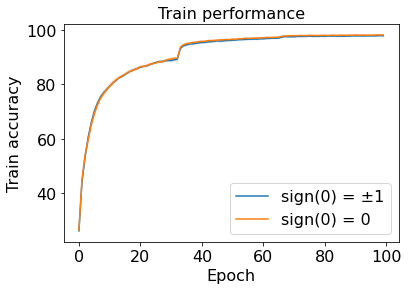

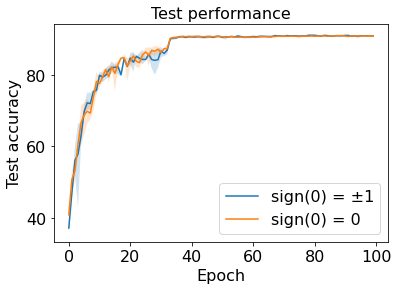

In [ ]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('font', size=16)
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=16)
plt.rc('figure', titlesize=16)

for rand_zero in rand_list:
    acc_array = np.zeros((100, 3))
    for seed in seed_list:
        train_accs, test_accs = results[lr, rand_zero, seed]
        acc_array[:,seed] = train_accs
    mean = np.mean(acc_array, axis=1)
    min = np.min(acc_array, axis=1)
    max = np.max(acc_array, axis=1)
    label = "sign(0) = ±1" if rand_zero else "sign(0) = 0"
    plt.plot(mean, label=label)
    plt.fill_between(range(100), y1=min, y2=max, alpha=0.2)
plt.xlabel('Epoch')
plt.ylabel('Train accuracy')
plt.title('Train performance')
plt.legend()
plt.show()

for rand_zero in rand_list:
    acc_array = np.zeros((100, 3))
    for seed in seed_list:
        train_accs, test_accs = results[lr, rand_zero, seed]
        acc_array[:,seed] = test_accs
    mean = np.mean(acc_array, axis=1)
    min = np.min(acc_array, axis=1)
    max = np.max(acc_array, axis=1)
    label = "sign(0) = ±1" if rand_zero else "sign(0) = 0"
    plt.plot(mean, label=label)
    plt.fill_between(range(100), y1=min, y2=max, alpha=0.2)
plt.xlabel('Epoch')
plt.ylabel('Test accuracy')
plt.title('Test performance')
plt.legend()
plt.show()